# This is a notebook for a link prediction pipeline for the Data distillery knowledge graph

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import polars as pl
import neo4j
from neo4j import GraphDatabase, basic_auth
import random
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import distinctipy
#from ast import literal_eval
#from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import graphdatascience
#import networkx as nx
#import umap

'''
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomNodeSplit'''
assert graphdatascience.__version__ == '1.8'

print(sys.version)

3.11.3 (main, Mar  6 2024, 17:13:49) [GCC 11.3.1 20220421 (Red Hat 11.3.1-2)]


In [5]:
!pip install networkx
import networkx

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 1.5 MB/s            


In [3]:
NEO4J_URI=''
NEO4J_USER=''
NEO4J_PASSWORD=''
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")

In [4]:
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD), database=NEO4J_DB)
print(f'Neo4j Python Driver Version: {neo4j.__version__}')
print(driver.verify_connectivity())

gds = graphdatascience.GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD),database=NEO4J_DB)

# Check the installed GDS version on the server
print(f'Python GDS Plugin Version: {graphdatascience.__version__}')
print(f'Neo4j GDS version: {gds.version()}')
assert gds.version() > '2.4'
# Test connection
r=gds.run_cypher('MATCH (N:Concept) RETURN COUNT(DISTINCT N);')
num_total_cuis = r.loc[0][0]
num_total_cuis

Neo4j Python Driver Version: 5.16.0
None
Python GDS Plugin Version: 1.8
Neo4j GDS version: 2.6.6


11026102

In [5]:
%%time

q="""WITH ['HGNC','HPO','UBERON'] AS SAB_LIST 
MATCH  (co1:Code)-[:CODE]-(c1:Concept)-[r]-(c2:Concept)-[:CODE]-(co2:Code ) 
WHERE  co1.SAB in SAB_LIST AND co2.SAB in SAB_LIST
RETURN DISTINCT  r.SAB;
"""

q="""
WITH ['HGNC','HPO','UBERON','CLINVAR', 'OMIM', 'MONDO', 'SNOMEDCT_US', 'DOID', 'ORPHANET', 'MP','GO', 'CL'] AS SAB_LIST
MATCH  (co1:Code)-[:CODE]-(c1:Concept)-[r]-(c2:Concept)-[:CODE]-(co2:Code ) 
WHERE  co1.SAB in SAB_LIST AND co2.SAB in SAB_LIST
RETURN DISTINCT  r.SAB
"""

r=gds.run_cypher(q)


KeyboardInterrupt



In [38]:
rels = [', '.join(['"{}"'.format(value) for value in rels])]

rels= ["HGNCHPO"]

In [46]:
q=f"""
WITH {rels} AS REL_LIST
MATCH  (co1:Code)-[:CODE]-(c1:Concept)-[r]-(c2:Concept)-[:CODE]-(co2:Code ) 
WHERE  r.SAB in REL_LIST 
//RETURN DISTINCT  co1.SAB
RETURN REL_LIST
"""


In [4]:
%%time
query_push_sab="""MATCH (c:Concept)-[:CODE]-(code:Code) 
SET c.SAB = code.SAB
SET c.code_id = code.CodeID;"""
r=gds.run_cypher(query_push_sab)

q="""MATCH (c:Concept) WHERE c.SAB = 'HGNC' SET c.SAB_CAT = 1"""
r=gds.run_cypher(q)

q="""MATCH (c:Concept) WHERE c.SAB = 'HPO' SET c.SAB_CAT = 2"""
r=gds.run_cypher(q)

query_push_all_sty = """MATCH (s:Semantic)-[r:STY]-(c:Concept) SET c.STY = s.name;"""
r=gds.run_cypher(query_push_all_sty)

query_push_all_term="""MATCH (t:Term)-[pt:PT]-(m:Code)<-[:CODE]-(n:Concept) WHERE n.CUI = pt.CUI
SET n.term = t.name """

r=gds.run_cypher(query_push_all_term)

query_onehotencode_create = \
"""MATCH (c:Concept) WHERE c.SAB IS NOT NULL AND c.STY IS NOT NULL 
WITH  COLLECT(distinct c.STY) AS distinct_sty, COLLECT(distinct c.SAB) AS distinct_sab
CREATE (:STY_Feature {features: distinct_sty})
CREATE  (:SAB_Feature {features: distinct_sab});"""

query_onehotencode_sty=\
"""MATCH (c:Concept) WHERE c.SAB IS NOT NULL AND c.STY IS NOT NULL  
MATCH (f:STY_Feature) SET c.one_hot_sty_label = gds.alpha.ml.oneHotEncoding(f.features,[c.STY]);"""

query_onehotencode_sab=\
"""MATCH (c:Concept) WHERE c.SAB IS NOT NULL AND c.STY IS NOT NULL  
MATCH (f:SAB_Feature) SET c.one_hot_sab =  gds.alpha.ml.oneHotEncoding(f.features,[c.SAB]);"""

query_onehotencode_delete_sty=""" MATCH (f:STY_Feature) DELETE f;"""

query_onehotencode_delete_sab=""" MATCH (f:SAB_Feature) DELETE f;"""

print('Creating nodes with categories as a property...')
gds.run_cypher(query_onehotencode_create)

print('Creating semantic type one hot encodings...')
gds.run_cypher(query_onehotencode_sty)

print('Creating SAB one hot encodings...')
gds.run_cypher(query_onehotencode_sab)

print('Removing nodes created in first step...')
gds.run_cypher(query_onehotencode_delete_sty)
gds.run_cypher(query_onehotencode_delete_sab)

a=gds.run_cypher("""MATCH (n:STY_Feature) RETURN n""")
b=gds.run_cypher("""MATCH (c:SAB_Feature) RETURN c""")

assert len(a) == 0 and len(b) == 0 # make sure feature nodes are deleted

Creating nodes with categories as a property...
Creating semantic type one hot encodings...
Creating SAB one hot encodings...


KeyboardInterrupt: 

In [16]:
# drop all previous graphs, if they exist
for GRAPH in ['newG','graph_from_df','f-graph','wholeG','largest_connected_components']:
    if gds.graph.exists(GRAPH)['exists']:
        G = gds.graph.get(GRAPH)
        print(f'Dropping {GRAPH}...')
        G.drop()

Dropping newG...


In [9]:
q="""LOAD CSV WITH HEADERS FROM 'file:///hgnc_hpo_uberon_sabs.csv' AS sab_file 
UNWIND sab_file.`r.SAB` AS sabs WITH COLLECT(sabs) AS sabsc  // 
MATCH (source:Concept)-[r1:associated_with|gene_associated_with_disease_or_phenotype]-(target:Concept)//-[r2]-(b:Concept)
WHERE source.SAB IN ['HGNC','HPO'] AND target.SAB IN ['HGNC','HPO'] AND source.SAB_CAT IN [1,2] AND target.SAB_CAT IN [1,2]
//AND a.SAB IN sabsc and b.SAB IN sabsc
//RETURN a.code_id, type(r0), source.code_id, type(r1), target.code_id, type(r2) LIMIT 1
WHERE source.SAB IN sabsc[0]
//WITH a,b,source,target, [type(r0)] + [type(r1)] + [type(r2)] as types
WITH collect(distinct type(r1)) as types //+ type(r1) + type(r2) AS types
RETURN  types limit 1
"""
r=gds.run_cypher(q)
r

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'WHERE': expected
  "!="
  "%"
  "*"
  "+"
  "-"
  "/"
  "<"
  "<="
  "<>"
  "="
  ">"
  ">="
  "AND"
  "CALL"
  "CREATE"
  "DELETE"
  "DETACH"
  "FOREACH"
  "LOAD"
  "MATCH"
  "MERGE"
  "NODETACH"
  "OPTIONAL"
  "OR"
  "REMOVE"
  "RETURN"
  "SET"
  "UNION"
  "UNWIND"
  "USE"
  "WITH"
  "XOR"
  "^"
  <EOF> (line 7, column 1 (offset: 532))
"WHERE source.SAB IN sabsc[0]"
 ^}

In [19]:
q="""LOAD CSV WITH HEADERS FROM 'file:///hgnc_hpo_uberon_sabs.csv' AS sab_file 
UNWIND sab_file.`r.SAB` AS sabs WITH COLLECT(sabs) AS sabsc 
MATCH (a:Concept)-[r0]-(source:Concept)-[r1:associated_with|gene_associated_with_disease_or_phenotype]-(target:Concept)
WHERE source.SAB IN ['HGNC','HPO'] AND target.SAB IN ['HGNC','HPO'] //AND source.SAB_CAT IN [1,2] AND target.SAB_CAT IN [1,2]
AND a.SAB IN sabsc[0..6]
//WITH collect(distinct type(r1)) as types , sabsc as s
RETURN  distinct a.SAB
"""
r=gds.run_cypher(q)
r

,a.SAB
0,NCI
1,MTH
2,OMIM


In [33]:
%%time
q="""LOAD CSV WITH HEADERS FROM 'file:///hgnc_hpo_uberon_sabs.csv' AS sab_file 
UNWIND sab_file.`r.SAB` AS sabs WITH COLLECT(sabs) AS sabsc 
MATCH (source:Concept)-[r1]->(target:Concept)
WHERE source.SAB IN sabsc AND target.SAB IN sabsc // AND NOT type(r1)  CONTAINS 'inverse_'
RETURN  distinct type(r1)
"""
r=gds.run_cypher(q)
r

CPU times: user 33.2 ms, sys: 8.03 ms, total: 41.2 ms
Wall time: 1min 6s


,type(r1)
0,RB
1,AQ
2,mapped_to
3,RO
4,inverse_isa
...,...
1465,disease_may_have_normal_tissue_origin
1466,relative_to_part_of
1467,internal_to
1468,allele_plays_role_in_metabolism_of_chemical_or...


In [17]:
%%time

GRAPH_NAME='newG'
#GRAPH_NAME='wholeG'

q=f"""
//LOAD CSV WITH HEADERS FROM 'file:///hgnc_hpo_uberon_sabs.csv' AS sab_file 
//UNWIND sab_file.`r.SAB` AS sabs WITH COLLECT(sabs) AS sabsc
WITH ['HGNC','HPO','UBERON','CLINVAR', 'OMIM', 'MONDO', 'SNOMEDCT_US', 'DOID', 'ORPHANET', 'MP','GO', 'CL'] as sabsc
MATCH (source:Concept)-[r1]->(target:Concept)
WHERE source.SAB IN sabsc// AND target.SAB IN sabsc
WITH gds.graph.project('{GRAPH_NAME}',source,target,
  {{
    sourceNodeLabels: ['Concept'],//labels(source),
    targetNodeLabels: ['Concept'],//labels(target),
    relationshipType: type(r1)
  }},
    {{  undirectedRelationshipTypes: ['*'] }}
    ) AS g        // 
RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
"""
#    sourceNodeProperties: source {{ SAB_CAT:  coalesce(source.SAB_CAT, -1), one_hot_sab: coalesce(source.one_hot_sab, [0]), one_hot_sty_label: coalesce(source.one_hot_sty_label, [0]) }},
#    targetNodeProperties: target {{ SAB_CAT: coalesce(target.SAB_CAT, -1),  one_hot_sab: coalesce(source.one_hot_sab, [0]), one_hot_sty_label: coalesce(target.one_hot_sty_label, [0]) }}
r=gds.run_cypher(q)
G = gds.graph.get(GRAPH_NAME)
r

CPU times: user 5.69 ms, sys: 2.75 ms, total: 8.44 ms
Wall time: 46.2 s


,graph,nodes,rels
0,newG,1655441,20338350


In [127]:
# Central Nervous System NP
GRAPH_NAME='cns_np'

q=f"""
MATCH (source:Concept)-[r]-(target:Concept) 
WHERE type(r) IN ['associated_with','gene_associated_with_disease_or_phenotype'] AND
source.SAB IN ['HGNC','HPO','UBERON'] AND target.SAB IN ['HGNC','HPO','UBERON'] AND source.SAB_CAT IN [1,2] AND target.SAB_CAT IN [1,2]
WITH gds.graph.project('{GRAPH_NAME}',source,target,
  {{
    sourceNodeLabels: ['Concept'],//labels(source),
    targetNodeLabels: ['Concept'],//labels(target),
    relationshipType: type(r),
    sourceNodeProperties: source {{ SAB_CAT:  coalesce(source.SAB_CAT, -1), one_hot_sab: coalesce(source.one_hot_sab, [0]), one_hot_sty_label: coalesce(source.one_hot_sty_label, [0]) }},
    targetNodeProperties: target {{ SAB_CAT: coalesce(target.SAB_CAT, -1),  one_hot_sab: coalesce(source.one_hot_sab, [0]), one_hot_sty_label: coalesce(target.one_hot_sty_label, [0]) }}
  }}, 
  {{  undirectedRelationshipTypes: ['*'] }}
  
  ) AS g        // 
RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
"""

r=gds.run_cypher(q)
G = gds.graph.get(GRAPH_NAME)
r

KeyboardInterrupt: 

In [ ]:
print(f'Node count: {G.node_count()}')
print(f'Node labels: {G.node_labels()}')
print(f'Node Properties: {G.node_properties()}')
print(f'Relationship count: {G.relationship_count()}')
print(f'Relationship types: {G.relationship_types()}')
print(f'Memory Usage: {G.memory_usage()}')
#relationship_properties #degree_distribution #density #configuration #creation_time #modification_time
# CALL gds.config.defaults.list({ username: 'Alicia', key: 'concurrency' })

In [18]:
# get id and props from main graph for mapping string properties later
q="""
MATCH (source:Concept)-[r]-(target:Concept) 
WHERE type(r) IN ['associated_with','gene_associated_with_disease_or_phenotype'] AND
source.SAB IN ['HGNC','HPO'] AND target.SAB IN ['HGNC','HPO']
RETURN DISTINCT id(source) as nodeId, labels(source) AS nodeLabels, source.STY as STY, 
source.SAB as SAB, source.code_id as codeID, source.term as term, source.SAB_CAT AS SAB_CAT
"""
r=gds.run_cypher(q)
ids = np.unique(r['nodeId'])

df_map = r
df_map.index = df_map['nodeId']
print(Counter([i[0] for i in df_map['nodeLabels']]))
df_map.head(5)

Counter()


,nodeId,nodeLabels,STY,SAB,codeID,term,SAB_CAT
nodeId,,,,,,,


In [ ]:
rel_str=', '.join(['"{}"'.format(value) for value in G.relationship_types()])

q=f"""CALL gds.graph.relationships.stream('{G.name()}', [{rel_str}] )
       YIELD sourceNodeId, targetNodeId, relationshipType"""
rels_df=gds.run_cypher(q)
rels_df.head(3)

In [ ]:
projected_props=list(set([x for xs in G.node_properties().values for x in xs]))
projected_props_strs=', '.join(['"{}"'.format(value) for value in projected_props])
query_get_node_df=f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",[{projected_props_strs}],{G.node_labels()},{{ listNodeLabels: true }})
YIELD nodeId, nodeProperty, propertyValue, nodeLabels
RETURN gds.util.asNode(nodeId).name AS name,nodeLabels,nodeId,nodeProperty,propertyValue"""

nodes_df = gds.run_cypher(query_get_node_df)
nodes_df.head(5)

In [ ]:
# Pivot the df, format and merge the nodeIDs back in 
nodes_df['nodeLabels'] = [i[0] for i in nodes_df['nodeLabels']]

# make label-nodeID mapping bc doing the pivot drops the label column
lbl_id_map = nodes_df[['nodeLabels','nodeId']]
lbl_id_map.index = lbl_id_map['nodeId']
lbl_id_map = lbl_id_map.drop_duplicates()

nodes_df = nodes_df.drop(['name'],axis=1)
nodes_df.index = nodes_df.nodeId 
nodes_df_pvt = pd.pivot(nodes_df,columns='nodeProperty',values='propertyValue').drop(['one_hot_sty_label'],axis=1)

nodes_df_pvt['nodeId'] = nodes_df_pvt.index
nodes_df_pvt = nodes_df_pvt.merge(lbl_id_map[['nodeLabels']], how='outer', left_index=True, right_index=True)
nodes_df_merge = nodes_df_pvt
nodes_df_merge

# change node labels to Gene and Phenotype

In [11]:
# Remove rows where node has the default one_hot_sab value of [0]
nodes_df_merge = nodes_df_merge[[len(i)>1 for i in nodes_df_merge['one_hot_sab']] ]

nodes_df_merge.loc[nodes_df_merge.SAB_CAT==1,'nodeLabels'] = 'Gene'
nodes_df_merge.loc[nodes_df_merge.SAB_CAT==2,'nodeLabels'] = 'Phenotype'

print(Counter(nodes_df_merge['SAB_CAT']))
print(Counter(nodes_df_merge['nodeLabels']))

Counter({2: 3454, 1: 1149})
Counter({'Phenotype': 3454, 'Gene': 1149})


In [12]:
# handle class imbalance by dropping some of the nodes where SAB_CAT == 2
label_2_drop = nodes_df_merge[nodes_df_merge['SAB_CAT']==2].sample(3454-1092).index.to_list()
nodes_df_merge = nodes_df_merge[~nodes_df_merge.index.isin(label_2_drop)]
nodes_df_merge = nodes_df_merge.rename(columns={'nodeLabels':'labels'})
#nodes_df_merge = nodes_df_merge.reset_index(drop=True)
Counter(nodes_df_merge['SAB_CAT'])

Counter({1: 1149, 2: 1092})

In [13]:
G = gds.graph.construct(
    "graph_from_df",      # Graph name
    nodes_df_merge,           # One or more dataframes containing node data
    rels_df,    # One or more dataframes containing relationship data
    undirected_relationship_types = G.relationship_types()
)

In [ ]:
del rels_df, projected_props_strs, projected_props,nodes_df, lbl_id_map, nodes_df_pvt, nodes_df_merge
del label_2_drop

In [14]:
print(f'Node count: {G.node_count()}')
print(f'Node labels: {G.node_labels()}')
print(f'Node Properties: {G.node_properties()}')
print(f'Relationship count: {G.relationship_count()}')
print(f'Relationship types: {G.relationship_types()}')
print(f'Memory Usage: {G.memory_usage()}')

Node count: 5098
Node labels: ['Phenotype', 'Gene', '__ALL__']
Node Properties: Phenotype    [SAB_CAT, one_hot_sab]
Gene         [SAB_CAT, one_hot_sab]
__ALL__                          []
dtype: object
Relationship count: 594792
Relationship types: ['gene_associated_with_disease_or_phenotype', 'associated_with']
Memory Usage: 10681 KiB


In [15]:
q=f"""CALL gds.graph.filter('f-graph','{G.name()}','n:Gene OR n:Phenotype','*')
YIELD graphName, fromGraphName, nodeCount, relationshipCount """
res=gds.run_cypher(q)
G = gds.graph.get('f-graph')
res

,graphName,fromGraphName,nodeCount,relationshipCount
0,f-graph,graph_from_df,2241,170952


In [16]:
#CALL gds.graph.relationships.toUndirected(
#    graphName: String,
#    configuration: Map)
#https://neo4j.com/docs/graph-data-science/current/management-ops/graph-update/to-undirected/

In [17]:
# if we just want to mutate a component ID onto the projected graph, just run this.
wcc_result = gds.wcc.mutate(G, mutateProperty="wccComponentId")

assert 'wccComponentId' in G.node_properties()[0]
print(f"Components found: {wcc_result.componentCount}")
#wcc_result

# Get additional information, instead of just mutating property
wcc_query = f"""
    CALL gds.graph.nodeProperties.stream('{G.name()}', 'wccComponentId')
    YIELD nodeId, propertyValue
    WITH nodeId AS node, propertyValue AS componentId// gds.util.asNode(nodeId).name AS node, propertyValue AS componentId
    WITH componentId, collect(node) AS comps
    WITH componentId, comps, size(comps) AS componentSize
    RETURN componentId, componentSize, comps ORDER BY componentSize DESC"""

components = gds.run_cypher(wcc_query)
largest_component = components["componentId"][0]


print(f"The largest component has the id {largest_component} with {components['componentSize'][0]} nodes.")

# For our further analysis we will work only with that subgraph.
largest_component_graph, _ = gds.beta.graph.project.subgraph(
    "largest_connected_components", G, f"n.wccComponentId={largest_component}", "*")

G = largest_component_graph # set new graph to G

# Remove wccComponentId property
q=f"""CALL gds.graph.nodeProperties.drop('{G.name()}', ['wccComponentId']) YIELD propertiesRemoved"""

gds.run_cypher(q)

# check that this largest component really has no disconnected nodes
wcc_result = gds.wcc.stream(G)
assert len(wcc_result['componentId'].unique()) == 1


Components found: 53
The largest component has the id 0 with 2182 nodes.


In [18]:
props = set()

In [19]:
#G.node_properties()['Concept']
#props.add('degreeCentrality')

In [20]:
if 'degreeCentrality' not in G.node_properties()[0]: 
    
    degree_centrality_result = gds.degree.mutate(G, mutateProperty="degreeCentrality")

    props.add('degreeCentrality')
    
    print(degree_centrality_result)

nodePropertiesWritten                                                  2182
centralityDistribution    {'min': 4.0, 'max': 3604.015594482422, 'p90': ...
mutateMillis                                                              0
postProcessingMillis                                                    106
preProcessingMillis                                                       0
computeMillis                                                             0
configuration             {'orientation': 'NATURAL', 'mutateProperty': '...
Name: 0, dtype: object


In [21]:
if 'pageRankScore' not in G.node_properties()[0]: 
    
    page_rank_result = gds.pageRank.mutate(G,mutateProperty="pageRankScore",maxIterations=20,dampingFactor=0.85)

    props.add('pageRankScore')

    print(page_rank_result)

mutateMillis                                                              0
nodePropertiesWritten                                                  2182
ranIterations                                                            20
didConverge                                                           False
centralityDistribution    {'min': 0.18404579162597656, 'max': 39.8129873...
postProcessingMillis                                                     38
preProcessingMillis                                                       0
computeMillis                                                           127
configuration             {'mutateProperty': 'pageRankScore', 'jobId': '...
Name: 0, dtype: object


In [22]:

if 'betweennessCentrality' not in G.node_properties()[0]:
    
    betweenness_centrality_result = gds.betweenness.mutate(G, mutateProperty="betweennessCentrality")

    props.add('betweennessCentrality')

    print(betweenness_centrality_result)

BetweennessCentrality: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:01<00:00, 51.73%/s]

nodePropertiesWritten                                                  2182
mutateMillis                                                              0
centralityDistribution    {'min': 0.0, 'max': 419475.9999998808, 'p90': ...
postProcessingMillis                                                    185
preProcessingMillis                                                       0
computeMillis                                                          2243
configuration             {'mutateProperty': 'betweennessCentrality', 'j...
Name: 0, dtype: object


In [23]:
community_props = set()

In [24]:
%%time

if 'lpaCommunityId' not in G.node_properties()[0]: 
    
    lpa_results = gds.labelPropagation.mutate(G, mutateProperty="lpaCommunityId")
    
    community_props.add('lpaCommunityId')
    
print(lpa_results)

mutateMillis                                                             0
nodePropertiesWritten                                                 2182
ranIterations                                                            4
didConverge                                                           True
communityCount                                                           4
communityDistribution    {'min': 3, 'p5': 3, 'max': 2170, 'p999': 2170,...
postProcessingMillis                                                    28
preProcessingMillis                                                      0
computeMillis                                                           44
configuration            {'nodeWeightProperty': None, 'mutateProperty':...
Name: 0, dtype: object
CPU times: user 6.15 ms, sys: 2.15 ms, total: 8.3 ms
Wall time: 121 ms


In [25]:
%%time

if 'louvainCommunityId' not in G.node_properties()[0]:
    
    lovain_result = gds.louvain.mutate(G, mutateProperty='louvainCommunityId')

    community_props.add('louvainCommunityId')

    print(lovain_result)

mutateMillis                                                             0
nodePropertiesWritten                                                 2182
modularity                                                          0.3107
modularities                      [0.29986909144454643, 0.310700189194567]
ranLevels                                                                2
communityCount                                                          15
communityDistribution    {'min': 3, 'p5': 3, 'max': 611, 'p999': 611, '...
postProcessingMillis                                                     2
preProcessingMillis                                                      0
computeMillis                                                         1041
configuration            {'mutateProperty': 'louvainCommunityId', 'jobI...
Name: 0, dtype: object
CPU times: user 9.07 ms, sys: 2.18 ms, total: 11.2 ms
Wall time: 1.09 s


In [26]:
#q_scale_props='''CALL gds.scaleProperties.mutate('myGraph', {nodeProperties: ['buildYear', 'avgReview'],
#  scaler: 'Mean', mutateProperty: 'hotelFeatures'}) YIELD nodePropertiesWritten, scalerStatistics'''

# Supported values are MinMax, Max, Mean, Log, Center, and StdScore, case insensitively.
# how to pick which one to use? need to look at distribution of property values, may need to log transform
# train/test distributions need to be similar
#props = props - {'degreeCentrality'} # dont include this??

scaled_props = set()
props_to_drop = set()
props = props - {'degreeCentrality'}

SCALE_METHOD='Mean'

for PROP in list(props): # EXCLUDE community_props here, no need to scale categorical properties
    scaled_prop_name = PROP+'_scale'
    #print(f'Scaling {PROP}, writing {scaled_prop_name} property')
    scale_res = gds.scaleProperties.mutate(G,nodeProperties=PROP, scaler=SCALE_METHOD,mutateProperty=scaled_prop_name) 
    scaled_props.add(scaled_prop_name)
    props_to_drop.add(PROP)
print(f'Scaled properties: {scaled_props}')

gds.graph.nodeProperties.drop(G,list(props_to_drop))
G.node_properties()

Scaled properties: {'pageRankScore_scale', 'degreeCentrality_scale', 'betweennessCentrality_scale'}


In [ ]:
# Drop old non-scaled properties
q=f"""CALL gds.graph.nodeProperties.drop('{G.name()}', ['pageRankScore']) YIELD propertiesRemoved"""

gds.run_cypher(q)

In [27]:
# properties to use as inputs for the embedding method
embedding_inputs = list(scaled_props | community_props)
print(embedding_inputs)

# names of the embedding properteis (hashgnn, graphsage, etc.)
embedding_props = set()
embedding_dimension = 128

['louvainCommunityId', 'pageRankScore_scale', 'lpaCommunityId', 'degreeCentrality_scale', 'betweennessCentrality_scale']


In [28]:
G.node_labels()

['Phenotype', 'Gene']

In [29]:
#from utils import plotting


def get_embeddings_and_plot(graph_obj,embedding_method, plot_by):
    '''Helper function to get the embedding vectors , do PCA and plot them in 2-D to see how well they seperate the nodes. Also
    will print how many unique vectors there are. '''
    
    # query node properties and return (embedding_method,SAB_CAT)
    query_get_props=f"""CALL gds.graph.nodeProperties.stream('{graph_obj.name()}',['{embedding_method}','SAB_CAT'],{graph_obj.node_labels()}, {{ listNodeLabels: true }})
    YIELD nodeId,nodeProperty,propertyValue,nodeLabels RETURN * """
    res = gds.run_cypher(query_get_props)
    res.index = res.nodeId  # Pivot df so that properties are columns 
    res['nodeLabels'] = [i[0] for i in res['nodeLabels']]
    rnz = pd.pivot(res,columns='nodeProperty',values='propertyValue')
    rnz['nodeId'] = rnz.index
    rnz = pd.merge(rnz,res[res.index.duplicated(keep='first')][['nodeLabels']], left_index=True, right_index=True).drop('nodeId',axis=1)
    
    rnz.reset_index(drop=True,inplace=True)
    
    unique_embeddings = len(np.unique(rnz[embedding_method]))  
    print(f'{embedding_method}:  # of unique embeddings: {unique_embeddings} out of {len(rnz)} total nodes\nusing {np.shape(rnz[embedding_method][0])} dimensions.')

    # JUST PLOT PCA-REDUCED EMBEDDINGS W/O COLORS/LABELS
    if plot_by=='None':
        df_emb = pd.DataFrame(rnz[embedding_method].tolist(), index= rnz.index).T
        pca = PCA(n_components=2,svd_solver='full'); pca.fit(df_emb)

        plot_map = pd.DataFrame(pca.components_,index=['pca1','pca2']).T; assert len(plot_map) == len(res)
        plt.figure(figsize=(5,5))
        plt.scatter(plot_map['pca1'], plot_map['pca2'], s=1)#,c=plot_map['colors'])


    colors = ['k','r','b','c']

    if plot_by=='NODE_LABEL':
        plt.figure(figsize=(5,5))
        ax_list = []
        labels_list = []
        DISTINCT_NODE_LABELS=rnz.nodeLabels.drop_duplicates()
        for N,LABEL in enumerate(DISTINCT_NODE_LABELS):
            #print(N,LABEL)
            df_temp = rnz[rnz['nodeLabels']==LABEL]
            df_emb = pd.DataFrame(df_temp[embedding_method].tolist(), index= df_temp.index).T
            pca = PCA(n_components=2,svd_solver='full'); pca.fit(df_emb)
            print()
            plot_map = pd.DataFrame(pca.components_,index=['pca1','pca2']).T; assert len(plot_map) == len(df_temp)
            #print(np.shape(plot_map))
            ax = plt.scatter(plot_map['pca1'], plot_map['pca2'], s=1, marker='o', color=colors[N])
            ax_list.append(ax)
            labels_list.append(LABEL)
        plt.legend(ax_list,labels_list,title=plot_by)

    
    if plot_by=='SAB_CAT':
        plt.figure(figsize=(5,5))
        ax_list = []
        sab_cat_list = []
        DISTINCT_SAB_CAT=rnz.SAB_CAT.drop_duplicates()
        for N,SAB_CAT in enumerate(DISTINCT_SAB_CAT):
                #print(N,SAB_CAT)   
                df_temp = rnz[rnz['SAB_CAT']==SAB_CAT]
                df_emb = pd.DataFrame(df_temp[embedding_method].tolist(), index= df_temp.index).T
                pca = PCA(n_components=2,svd_solver='full'); pca.fit(df_emb)
                plot_map = pd.DataFrame(pca.components_,index=['pca1','pca2']).T; assert len(plot_map) == len(df_temp)
                ax = plt.scatter(plot_map['pca1'], plot_map['pca2'], s=1, marker='o', color=colors[N])
                ax_list.append(ax)
                sab_cat_list.append(SAB_CAT)  
                
        plt.legend(ax_list,sab_cat_list,title=plot_by)
    #print(pca.explained_variance_ratio_)
    plt.xlabel(np.round(pca.explained_variance_ratio_[0]*100,2))
    plt.ylabel(np.round(pca.explained_variance_ratio_[1]*100,2))
        

fastrp_embeddings:  # of unique embeddings: 1891 out of 2182 total nodes
using (128,) dimensions.


CPU times: user 3.56 s, sys: 6.8 s, total: 10.4 s
Wall time: 701 ms


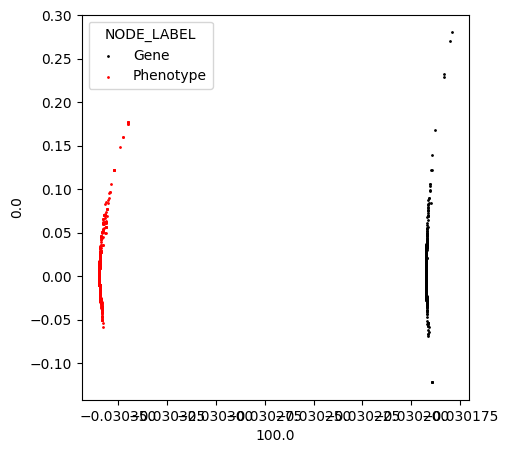

In [30]:
%%time

if 'fastrp_embeddings' not in G.node_properties()[0]: 
    
    fastrp_result = gds.fastRP.mutate(
        G, featureProperties=embedding_inputs, 
        embeddingDimension=embedding_dimension, propertyRatio=0.4,
        iterationWeights = [0.8, 1, 1, 1], mutateProperty="fastrp_embeddings")  #relationshipWeightProperty="cost",)

    embedding_props.add('fastrp_embeddings')

get_embeddings_and_plot(graph_obj=G,embedding_method='fastrp_embeddings',plot_by='NODE_LABEL')
#get_embeddings_and_plot(graph_obj=G,embedding_method='fastrp_embeddings',plot_by='SAB_CAT')

HashGNN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:14<00:00,  6.75%/s]


hashgnn_embeddings:  # of unique embeddings: 5 out of 2182 total nodes
using (128,) dimensions.




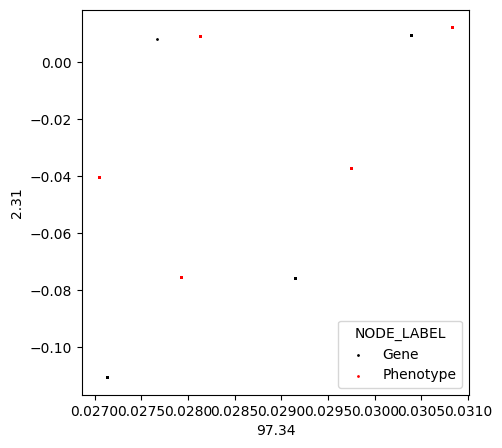

In [31]:

if 'hashgnn_embeddings' not in G.node_properties()[0]:

    hashgnn_result = gds.hashgnn.mutate(G, heterogeneous = True,
                       iterations = 120,
                       embeddingDensity = embedding_dimension//2,
                       neighborInfluence=0.7,
                       mutateProperty='hashgnn_embeddings',
                       binarizeFeatures = {'dimension' : 64, 'threshold' : 0.2},
                       featureProperties = embedding_inputs,
                       outputDimension = embedding_dimension, # dim of hashgnn_embedding
                       #contextNodeLabels = G.node_labels(), 
                       randomSeed = 42)

    embedding_props.add('hashgnn_embeddings')
    #print(hashgnn_result)
    
get_embeddings_and_plot(graph_obj=G,embedding_method='hashgnn_embeddings',plot_by='NODE_LABEL')   
#get_embeddings_and_plot(graph_obj=G,embedding_method='hashgnn_embeddings',plot_by='SAB_CAT')

In [63]:
q=f"""CALL gds.graph.nodeProperties.drop('{G.name()}', ['graphsage_embeddings','node2vec_embeddings']) YIELD propertiesRemoved"""

gds.run_cypher(q)

,propertiesRemoved
0,4364


node2vec_embeddings:  # of unique embeddings: 2182 out of 2182 total nodes
using (128,) dimensions.


CPU times: user 3.59 s, sys: 5.96 s, total: 9.55 s
Wall time: 3.05 s


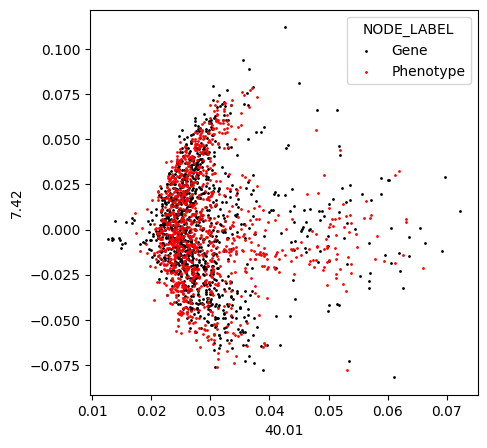

In [64]:
%%time

if 'node2vec_embeddings' not in G.node_properties()[0]:
    
    node2vec_result = gds.node2vec.mutate(G,
                        embeddingDimension = embedding_dimension,
                        walkLength=8,
                        walksPerNode=10,
                        iterations=10,
                        inOutFactor=1,
                        mutateProperty='node2vec_embeddings')

    embedding_props.add('node2vec_embeddings')
    #print(node2vec_result)
        
get_embeddings_and_plot(graph_obj=G,embedding_method='node2vec_embeddings',plot_by='NODE_LABEL')
#get_embeddings_and_plot(graph_obj=G,embedding_method='node2vec_embeddings',plot_by='SAB_CAT')

In [ ]:
m=gds.model.get('newGmodel')
gds.model.drop(m)


GraphSageTrain:   0%|                                                                                                                    | 0/100 [00:00<?, ?%/s]
GraphSageTrain:   1%|▊                                                                                                        | 0.72/100 [00:00<01:13,  1.35%/s]
GraphSageTrain:   1%|▉                                                                                                        | 0.92/100 [00:01<02:07,  1.29s/%]
GraphSageTrain:   1%|█▏                                                                                                       | 1.12/100 [00:01<02:46,  1.69s/%]
GraphSageTrain:   1%|█▍                                                                                                       | 1.31/100 [00:02<03:17,  2.00s/%]
GraphSageTrain:   1%|█▌                                                                                                       | 1.47/100 [00:02<03:50,  2.34s/%]
GraphSageTrain:   2%|█▋          

graphsage_embeddings:  # of unique embeddings: 1938 out of 2182 total nodes
using (128,) dimensions.




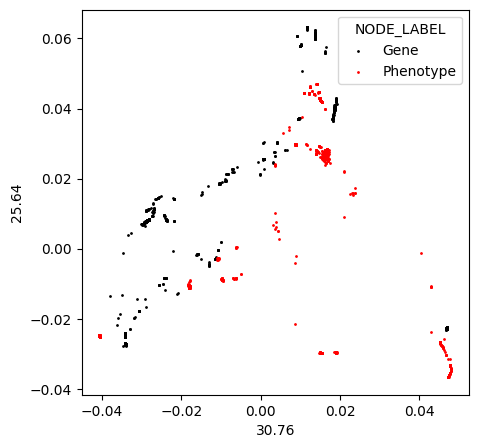

In [65]:
# Train first then mutate
# More layers result in more distant neighbors being considered for a node’s embedding. 

GRAPHSAGE_EMB_NAME = 'graphsage_embeddings'

if GRAPHSAGE_EMB_NAME not in G.node_properties()[0]:
    
    GRAPH_SAGE_MODEL_NAME='newGmodel'

    gs_model, graphSageTrain_results = gds.beta.graphSage.train(G,
                                     modelName = GRAPH_SAGE_MODEL_NAME,
                                     featureProperties = embedding_inputs,
                                     embeddingDimension = embedding_dimension,
                                     #projectedFeatureDimension = embedding_dimension,
                                     aggregator= 'pool',   # 'mean' is faster
                                     activationFunction= 'ReLu', #'sigmoid',
                                     sampleSizes = [25, 10], # defines num_layers and size of each layer 
                                     epochs = 20,
                                     maxIterations = 50,
                                     randomseed=19)
    # write to graph
    gs_result = gds.beta.graphSage.mutate(G, mutateProperty = GRAPHSAGE_EMB_NAME, modelName =  MODEL_NAME)
    embedding_props.add(GRAPHSAGE_EMB_NAME)
    #print(gs_result)
    
get_embeddings_and_plot(graph_obj=G,embedding_method=GRAPHSAGE_EMB_NAME,plot_by='NODE_LABEL')   
#get_embeddings_and_plot(graph_obj=G,embedding_method=GRAPHSAGE_EMB_NAME,plot_by='SAB_CAT')

In [56]:
embedding_props

{'fastrp_embeddings',
 'graphsage_embeddings',
 'hashgnn_embeddings',
 'node2vec_embeddings'}

In [70]:
def configure_link_pred_pipeline(EMBEDDING_METHOD,NEG_REL_TYPE,NODE_PROPERTIES):

    # Create Pipeline
    PIPELINE_NAME= "link-pred-pipe-" + EMBEDDING_METHOD.split('_')[0]

    try:
        pipe = gds.beta.pipeline.linkPrediction.create(PIPELINE_NAME)  #nodeClassification.create(PIPELINE_NAME)
    except Exception as e: print(e)  

    pipename= gds.beta.pipeline.list()['pipelineName'][0]
    pipe = gds.pipeline.get(pipename)
    
    try:
        _ = pipe.configureSplit(testFraction=0.25,trainFraction=0.6,validationFolds=5,negativeSamplingRatio=1.0,
                              negativeRelationshipType = NEG_REL_TYPE)
    except Exception as e:  print(e)  
        
    try:
        pipe.configureAutoTuning(maxTrials=60)
    except Exception as e: print(e) 
    
    #feature_type='L2' # or 'COSINE', 'HADAMARD', 'SAME_CATEGORY'
    try:
        pipe.addFeature(feature_type='L2',nodeProperties= [NODE_PROPERTIES])
    except Exception as e: print(e) 
            
    return pipe,PIPELINE_NAME



def add_link_prediction_models(pipe):
    
    try:
        _ = pipe.addLogisticRegression(penalty=(0.1, 1.0), maxEpochs=1000, patience=(1,5), tolerance=0.0001, learningRate=0.01)
    except Exception as e: print(e)  
                
    try:
        _ = pipe.addRandomForest(minSplitSize=(2, 100), criterion="ENTROPY")
    except Exception as e: print(e)
            
    # https://neo4j.com/docs/graph-data-science/current/machine-learning/training-methods/mlp/#_batch_size        
    try:
        _ = pipe.addMLP(patience=(1,3),maxEpochs=1000,hiddenLayerSizes=[12,32,32,12],tolerance=1e-4,
                        learningRate=0.001,batchSize=100,)
    except Exception as e: print(e)  
    return pipe


def train_pipeline(EMBEDDING_METHOD,SOURCE_NODE_LABEL,TARGET_NODE_LABEL,TARGET_REL_TYPE):

    model_name = "link-pred-model-" + EMBEDDING_METHOD.split('_')[0]
    try: 
        model, stats= pipe.train(
                    G,
                    modelName=model_name,
                    sourceNodeLabel=SOURCE_NODE_LABEL,
                    targetNodeLabel=TARGET_NODE_LABEL,
                    targetRelationshipType=TARGET_REL_TYPE, 
                    metrics=['AUCPR', 'OUT_OF_BAG_ERROR'], # 'F1_MACRO',
                    randomSeed=np.random.randint(10000))
    except Exception as e: print(e)   
    return model,stats, pipe,model_name

# Link Prediction Pipeline

In [ ]:
MODEL_NAME="gene-predictor-model"
if gds.model.exists(MODEL_NAME)['exists']:
    gds.model.drop(MODEL_NAME)

PIPELINE_NAME= "gene-predictor-pipe"
if gds.pipeline.exists(PIPELINE_NAME)['exists']:
    gds.pipeline.drop(PIPELINE_NAME)
    #gds.pipeline.get(PIPELINE_NAME).drop()
#pipe.drop(); 

In [74]:
MODELS = dict()
STATS = dict()
PIPELINES = dict()
PREDS = dict()

for EMBEDDING_METHOD in embedding_props:
    print(f'Using {EMBEDDING_METHOD} to train and test a link prediction pipeline.')

    print('Configuring...')
    pipe, pipeline_name = configure_link_pred_pipeline(EMBEDDING_METHOD=EMBEDDING_METHOD,
                                        NEG_REL_TYPE='gene_associated_with_disease_or_phenotype',
                                        NODE_PROPERTIES='fastrp_embeddings')
    print('Adding models...')
    pipe = add_link_prediction_models(pipe)
    
    print('Training models...')
    model,stats, pipe, model_name = train_pipeline(EMBEDDING_METHOD=EMBEDDING_METHOD, SOURCE_NODE_LABEL='Gene',
               TARGET_NODE_LABEL='Phenotype', TARGET_REL_TYPE='gene_associated_with_disease_or_phenotype')
    
    PIPELINES[pipeline_name] = pipe
    MODELS[model_name] = model.model_info()
    STATS[EMBEDDING_METHOD+'_stats'] = stats
    
    print(model.metrics()['AUCPR'])
    predictions = model.predict_stream(G,topN=100,threshold=0.45)
    
    PREDS[EMBEDDING_METHOD+'_predictions'] = predictions
    if EMBEDDING_METHOD!='hashgnn_embeddings':
        gds.model.get(model_name).drop()
    print('###########################################\n')

Using fastrp_embeddings to train and test a link prediction pipeline.
Configuring...
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
Adding models...
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
Training models...



Link Prediction Train Pipeline:   0%|                                                                                                    | 0/100 [00:00<?, ?%/s]
Link Prediction Train Pipeline:   6%|█████▏                                                                                   | 5.77/100 [00:00<00:08, 11.42%/s]
Link Prediction Train Pipeline:   7%|██████▌                                                                                  | 7.42/100 [00:01<00:13,  6.62%/s]
Link Prediction Train Pipeline:  11%|█████████▍                                                                              | 10.71/100 [00:01<00:13,  6.57%/s]
Link Prediction Train Pipeline:  12%|██████████▉                                                                             | 12.36/100 [00:02<00:16,  5.27%/s]
Link Prediction Train Pipeline:  14%|████████████▎                                                                           | 14.01/100 [00:02<00:18,  4.55%/s]
Link Prediction Train Pipeline:  

(test=0.7566137566137566, outer_train=0.7172413793103448, train=(min=0.7155172413793103, avg=0.7172413793103448, max=0.7176724137931034), validation=(min=0.7155172413793103, avg=0.7172413793103447, max=0.7241379310344828))



Link Prediction Predict Pipeline:   0%|                                                                                                  | 0/100 [00:00<?, ?%/s]
Link Prediction Predict Pipeline:  36%|███████████████████████████████                                                       | 36.16/100 [00:00<00:00, 72.04%/s]
Link Prediction Predict Pipeline:  53%|█████████████████████████████████████████████▎                                        | 52.75/100 [00:01<00:00, 49.05%/s]
Link Prediction Predict Pipeline:  85%|█████████████████████████████████████████████████████████████████████████▍            | 85.33/100 [00:01<00:00, 56.23%/s]
Link Prediction Predict Pipeline: 100%|██████████████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:02<00:00, 49.07%/s]


###########################################

Using node2vec_embeddings to train and test a link prediction pipeline.
Configuring...
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
Adding models...
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
Training models...



Link Prediction Train Pipeline:   0%|                                                                                                    | 0/100 [00:00<?, ?%/s]
Link Prediction Train Pipeline:  10%|████████▊                                                                               | 10.05/100 [00:00<00:04, 19.92%/s]
Link Prediction Train Pipeline:  17%|██████████████▋                                                                         | 16.65/100 [00:01<00:05, 15.87%/s]
Link Prediction Train Pipeline:  22%|███████████████████▌                                                                    | 22.26/100 [00:01<00:05, 13.69%/s]
Link Prediction Train Pipeline:  24%|█████████████████████                                                                   | 23.91/100 [00:02<00:07,  9.58%/s]
Link Prediction Train Pipeline:  28%|████████████████████████▌                                                               | 27.87/100 [00:02<00:08,  8.95%/s]
Link Prediction Train Pipeline:  

(test=0.5184574198160659, outer_train=0.4523704830184859, train=(min=0.4020400416417911, avg=0.42840227908885053, max=0.45242261562707825), validation=(min=0.4712221976974563, avg=0.5089205954688202, max=0.5468484497682207))
###########################################

Using graphsage_embeddings to train and test a link prediction pipeline.
Configuring...
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
Adding models...
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.Database


Link Prediction Train Pipeline:   0%|                                                                                                    | 0/100 [00:00<?, ?%/s]
Link Prediction Train Pipeline:   6%|█████▏                                                                                   | 5.77/100 [00:00<00:08, 11.45%/s]
Link Prediction Train Pipeline:  12%|██████████▌                                                                             | 12.03/100 [00:01<00:07, 12.00%/s]
Link Prediction Train Pipeline:  15%|█████████████▍                                                                          | 15.33/100 [00:01<00:08,  9.50%/s]
Link Prediction Train Pipeline:  18%|███████████████▊                                                                        | 17.97/100 [00:02<00:10,  7.81%/s]
Link Prediction Train Pipeline:  19%|████████████████▉                                                                       | 19.29/100 [00:02<00:13,  5.94%/s]
Link Prediction Train Pipeline:  

(test=0.4891134270227496, outer_train=0.42938399768607194, train=(min=0.40432822869534657, avg=0.4238543998151395, max=0.4380287620299495), validation=(min=0.4068408169350311, avg=0.472863541706363, max=0.5532031727461107))
###########################################

Using hashgnn_embeddings to train and test a link prediction pipeline.
Configuring...
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
Adding models...
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseError.Statement.ExecutionFailed} {message: Expected positive long value, got -24}
{code: Neo.DatabaseErr


Link Prediction Train Pipeline:   0%|                                                                                                    | 0/100 [00:00<?, ?%/s]
Link Prediction Train Pipeline:   5%|████▊                                                                                    | 5.44/100 [00:00<00:08, 10.78%/s]
Link Prediction Train Pipeline:   7%|██████▌                                                                                  | 7.42/100 [00:01<00:13,  6.73%/s]
Link Prediction Train Pipeline:   9%|████████                                                                                 | 9.06/100 [00:01<00:17,  5.14%/s]
Link Prediction Train Pipeline:  10%|█████████▏                                                                              | 10.38/100 [00:02<00:21,  4.14%/s]
Link Prediction Train Pipeline:  12%|██████████▉                                                                             | 12.36/100 [00:02<00:21,  4.05%/s]
Link Prediction Train Pipeline:  

(test=0.5304658270366518, outer_train=0.438686793183065, train=(min=0.3771928517842398, avg=0.40830309335853326, max=0.4368636400838112), validation=(min=0.42191256626262735, avg=0.4797705007082177, max=0.52351939431323))
###########################################



In [73]:
for pipe_name in gds.pipeline.list()['pipelineName']:
    print(f'Dropping pipeline: {pipe_name}')
    gds.pipeline.get(pipe_name).drop()
    
for model_name in gds.model.list()['modelName']:
    if model_name is not GRAPH_SAGE_MODEL_NAME:
        print(f'Dropping model: {model_name}')
        gds.model.get(model_name).drop()


Dropping pipeline: link-pred-pipe-fastrp
Dropping model: newGmodel
Dropping model: link-pred-model-fastrp


In [43]:
STATS['fastrp_embeddingsstats']['configuration']

{'randomSeed': 4973,
 'targetRelationshipType': 'gene_associated_with_disease_or_phenotype',
 'jobId': '657afa7f-1c01-4bc7-8606-c780762866d1',
 'graphName': 'largest_connected_components',
 'sudo': False,
 'negativeClassWeight': 1.0,
 'storeModelToDisk': False,
 'modelName': 'link-pred-model-fastrp',
 'logProgress': True,
 'metrics': ['AUCPR', 'OUT_OF_BAG_ERROR'],
 'pipeline': 'link-pred-pipe-fastrp',
 'concurrency': 4,
 'sourceNodeLabel': 'Gene',
 'targetNodeLabel': 'Phenotype'}

In [42]:
MODELS['link-pred-model-fastrp']   # [model.best_parameters(), model.model_info()] 

[minEpochs                              1
 maxEpochs                           1000
 focusWeight                          0.0
 patience                               2
 tolerance                         0.0001
 learningRate                       0.001
 hiddenLayerSizes        [12, 32, 32, 12]
 batchSize                            100
 penalty                              0.0
 methodName          MultilayerPerceptron
 classWeights                          []
 dtype: object,
 modelName                                       link-pred-model-fastrp
 modelType                                               LinkPrediction
 metrics              {'AUCPR': {'test': 0.7506666666666666, 'valida...
 pipeline             {'nodePropertySteps': [], 'featureSteps': [{'n...
 bestParameters       {'minEpochs': 1, 'maxEpochs': 1000, 'focusWeig...
 nodePropertySteps                                                   []
 featureSteps         [{'name': 'L2', 'config': {'nodeProperties': [...
 dtype: object]

In [68]:
model.best_parameters()

ValueError: There is no 'link-pred-model-node2vec' in the model catalog

In [58]:
model.model_info()
print(model.metrics()['AUCPR'])

(test=0.7475, outer_train=0.7091194968553459, train=(min=0.7086614173228346, avg=0.7091184190211518, max=0.7098039215686275), validation=(min=0.7063492063492063, avg=0.7091021825396826, max=0.7109375))


In [75]:
PREDS['hashgnn_embeddings_predictions'].tail(5) #.compare(PREDS['fastrp_embeddings_predictions'])

,node1,node2,probability
95,434350,2525232,0.555869
96,510999,2848648,0.555869
97,85208,3601415,0.555869
98,577761,2589461,0.555869
99,3437634,3704903,0.555869


In [76]:
PREDS['fastrp_embeddings_predictions'].tail(5) 

,node1,node2,probability
95,4100231,4234304,0.5
96,4100231,4234295,0.5
97,4100231,4234287,0.5
98,4100231,4113747,0.5
99,4100231,4110023,0.5


In [77]:
MODELS['link-pred-model-hashgnn']

[minEpochs                        1
 maxEpochs                     1000
 focusWeight                    0.0
 patience                         2
 tolerance                   0.0001
 learningRate                  0.01
 batchSize                      100
 penalty                   0.618539
 methodName      LogisticRegression
 classWeights                    []
 dtype: object,
 modelName                                      link-pred-model-hashgnn
 modelType                                               LinkPrediction
 metrics              {'AUCPR': {'test': 0.5304658270366518, 'valida...
 pipeline             {'nodePropertySteps': [], 'featureSteps': [{'n...
 bestParameters       {'minEpochs': 1, 'maxEpochs': 1000, 'focusWeig...
 nodePropertySteps                                                   []
 featureSteps         [{'name': 'L2', 'config': {'nodeProperties': [...
 dtype: object]

In [137]:
MODELS['link-pred-model-fastrp'][1]

modelName                                       link-pred-model-fastrp
modelType                                               LinkPrediction
metrics              {'AUCPR': {'test': 0.5035223549981797, 'valida...
pipeline             {'nodePropertySteps': [], 'featureSteps': [{'n...
bestParameters       {'minEpochs': 1, 'maxEpochs': 1000, 'focusWeig...
nodePropertySteps                                                   []
featureSteps         [{'name': 'L2', 'config': {'nodeProperties': [...
dtype: object

In [78]:
MODELS['link-pred-model-node2vec'][1]['metrics']

{'AUCPR': {'test': 0.5184574198160659,
  'validation': {'min': 0.4712221976974563,
   'max': 0.5468484497682207,
   'avg': 0.5089205954688202},
  'outerTrain': 0.4523704830184859,
  'train': {'min': 0.4020400416417911,
   'max': 0.45242261562707825,
   'avg': 0.42840227908885053}}}

In [79]:
MODELS['link-pred-model-fastrp'][1]['metrics']

{'AUCPR': {'test': 0.7566137566137566,
  'validation': {'min': 0.7155172413793103,
   'max': 0.7241379310344828,
   'avg': 0.7172413793103447},
  'outerTrain': 0.7172413793103448,
  'train': {'min': 0.7155172413793103,
   'max': 0.7176724137931034,
   'avg': 0.7172413793103448}}}

In [80]:
MODELS['link-pred-model-hashgnn'][1]['metrics']

{'AUCPR': {'test': 0.5304658270366518,
  'validation': {'min': 0.42191256626262735,
   'max': 0.52351939431323,
   'avg': 0.4797705007082177},
  'outerTrain': 0.438686793183065,
  'train': {'min': 0.3771928517842398,
   'max': 0.4368636400838112,
   'avg': 0.40830309335853326}}}

In [81]:
MODELS['link-pred-model-graphsage'][1]['metrics']

{'AUCPR': {'test': 0.4891134270227496,
  'validation': {'min': 0.4068408169350311,
   'max': 0.5532031727461107,
   'avg': 0.472863541706363},
  'outerTrain': 0.42938399768607194,
  'train': {'min': 0.40432822869534657,
   'max': 0.4380287620299495,
   'avg': 0.4238543998151395}}}

In [83]:
predictions = PREDS['hashgnn_embeddings_predictions']

In [ ]:
predictions = model.predict_stream(G,topN=100,threshold=0.45)
predictions

In [110]:
query_get_props=f"""CALL gds.graph.nodeProperties.stream("{G.name()}",['SAB_CAT'],{G.node_labels()},{{ listNodeLabels: true }})
                    YIELD nodeId, nodeProperty, propertyValue, nodeLabels
                    RETURN gds.util.asNode(nodeId).name AS name,nodeLabels,nodeId,nodeProperty,propertyValue"""

res = gds.run_cypher(query_get_props)

# Pivot df so that algo scores are columns 
res.index = res.nodeId  
rnzp = pd.pivot(res,columns='nodeProperty',values='propertyValue')

# Merge in string props (codeID, Term name)
rnzp['nodeId'] = rnzp.index
rnzp.reset_index(drop=True,inplace=True)

df_props = pd.merge(rnzp,df_map.drop('SAB_CAT',axis=1).reset_index(drop=True),on='nodeId')
assert len(rnzp) == len(df_props)


predictions['pred_key'] = [str(i) + '_' + str(j) for i,j in zip(predictions['node1'],predictions['node2'])]

# merge/annotate in node1
df_pred_1 = pd.merge(predictions,df_props[['nodeId','codeID','term']], left_on='node1', right_on='nodeId',how='left')  
df_pred_1 = df_pred_1.rename(columns={'codeID':'codeID_node1','term':'term_1'}).drop(['node1','nodeId','node2'],axis=1)

# merge/annotate in node2
df_pred_2 = pd.merge(predictions,df_props[['nodeId','codeID','term']], left_on='node2', right_on='nodeId',how='left')  
df_pred_2 = df_pred_2.rename(columns={'codeID':'codeID_node2','term':'term_2'}).drop(['node1','nodeId','node2'],axis=1)

df_pred = pd.merge(df_pred_1,df_pred_2).drop('pred_key',axis=1)
assert len(predictions) == len(df_pred)
df_pred = df_pred.fillna(value='None')
df_pred.sort_values('probability',ascending=False)

,probability,pred_key,codeID_node1,term_1,codeID_node2,term_2
0,0.555869,310472_3895392,HPO:0003730,None,HGNC:28320,protein phosphatase 1 regulatory subunit 35
1,0.555869,1889959_3895392,HPO:0003531,None,HGNC:28320,protein phosphatase 1 regulatory subunit 35
2,0.555869,1889952_3895392,HPO:0002906,None,HGNC:28320,protein phosphatase 1 regulatory subunit 35
3,0.555869,1889939_3895392,HPO:0003525,None,HGNC:28320,protein phosphatase 1 regulatory subunit 35
4,0.555869,4482037_7272399,HPO:0032676,Chronic cutaneous wound,HGNC:16692,CD320 ANTIGEN
...,...,...,...,...,...,...
95,0.555869,434350_2525232,HGNC:4136,GAMT Gene,HPO:0007341,Diffuse swelling of cerebral white matter
96,0.555869,510999_2848648,HGNC:3226,EPHRIN B1,HPO:0025082,Abnormal cutaneous elastic fiber morphology
97,0.555869,85208_3601415,HPO:0003460,Decreased circulating total IgA,HGNC:5962,IL10 Gene
98,0.555869,577761_2589461,HGNC:6553,LEP Gene,HPO:0003524,Decreased methionine synthase activity


In [107]:
# get all hgnc code/terms in the code1,term1 columns so its easier to compare.
# need to make sure direction of prediction is not included in the models prediction
# or this will be incorrect

for idx, row in df_pred.iterrows():
    if row['codeID_node1'].startswith('HPO'):
        print(row['codeID_node1'])
        df_pred.loc[idx,['codeID_node1','codeID_node2']] = df_pred.loc[idx,['codeID_node2','codeID_node1']].values
        df_pred.loc[idx,['term_1','term_2']] = df_pred.loc[idx,['term_2','term_1']].values
        
df_pred = df_pred[['codeID_node1', 'term_1', 'codeID_node2','term_2','probability']]
df_pred